# DSCI 572 "lecture" 6

## The plan

- Quiz 1 debrief (30 min)
- Classification / softmax (15 min)
- Loss vs. accuracy (5 min)
- Break (5 min)
- Optimization and early stopping (10 min)
- Hyperparameters (5 min)
- Convolutions (10 min)
- ~~Convolution T/F questions (15 min)~~

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils

from sklearn import datasets
from sklearn.model_selection import train_test_split

In [2]:
plt.rcParams['font.size'] = 16

## Quick vocabulary clarification: layers

- The number of layers != the number of _hidden_ layers.
- Back to this picture;

![](https://upload.wikimedia.org/wikipedia/commons/4/46/Colored_neural_network.svg)

This network (and the one in lab 3 Exercise 0) has:

- 1 hidden layer
- 2 layers (2 transformations, 2 sets of weights)

In general, the number of layers is always one more than the number of hidden layers.

## Quiz 1 debrief (15 min)

(Go to Canvas)

## Classification / softmax (15 min)

- To use a neural net for classification, we take advantage of the fact that the output doesn't have to be 1-dimensional ($k>1$)
- For example, with the digits dataset there are $10$ classes, so we set the size of the last layer to $c=10$
- The output will be the probabilities for the 10 classes. 
- For the last layer, we use a special activation function called the **softmax**:

$$h(z_i) = \frac{\exp(z_i)}{\sum_{k=1}^c \exp(z_j)}$$

where $z_i$ is the $i$th element of $z$, and $c$ is the number of classes.

Softmax intuition:

- Probabilities need to be non-negative (hence exp)
- Probabilities must sum to 1 (hence dividng by the sum)

Actually:

- This is not the "real" intuition but it gets the job done. 
- It's actually the "soft max" because it's like the max function but "soft"

Optional note:

- This function is the analog of the sigmoid in logistic regression.
- If you think of $z=[w^Tx, 0]$ then you get $h(z)=\left[\frac{\exp(w^Tx)}{\exp(w^Tx)+1},\; \frac{1}{\exp(w^Tx)+1}\right]$, or equivalently $\left[\frac{1}{1+\exp(-w^Tx)},\; \frac{1}{\exp(w^Tx)+1}\right]$ which are indeed the probability you get from the sigmoid, and 1 minus the probability you get from the sigmoid.  

In [3]:
h_softmax = lambda z: np.exp(z)/np.sum(np.exp(z))

z = [-5, -1, 3, 7, 5]

In [4]:
np.max(z)

7

In [5]:
(z == np.max(z)).astype(float)

array([0., 0., 0., 1., 0.])

In [6]:
h_softmax(z)

array([5.32430861e-06, 2.90697400e-04, 1.58715403e-02, 8.66556737e-01,
       1.17275701e-01])

In [7]:
np.sum(h_softmax(z)) # should be 1

1.0

In [8]:
z = [-5, -1, 3, 100, 5]

In [9]:
h_softmax(z)

array([2.50656748e-46, 1.36853947e-44, 7.47197234e-43, 1.00000000e+00,
       5.52108228e-42])

BTW, remember Lab 2 Exercise 5? You had to deal with numerical issues using

$$\begin{align}\log \displaystyle\sum_{k=1}^c \exp(z_k)=a+ \log \displaystyle\sum_{k=1}^c \exp(z_k-a)\end{align}$$

- This comes from the softmax loss, aka the categorical cross-entropy loss.
- The loss tries to make the probability of the correct class large.
- Which forces the rest to be small since they must add to 1.
- It's a generalization of the logistic loss to multi-class.
- It's the exact same loss as multinomial (aka softmax) logistic regression.
- (Optional) the full loss is

$$f(W)=-w_{y_i}^Tx_i+\log \displaystyle\sum_{k=1}^c \exp(w^T_kx_i)$$

In [10]:
digits = datasets.load_digits()
X = digits['data']/255
y = digits['target']

In [11]:
y.shape

(1797,)

It seems this is no longer necessary, but that's OK:

In [12]:
Y = utils.to_categorical(y, 10) # make it 1-hot

In [13]:
Y.shape

(1797, 10)

In [14]:
print(Y)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


Above: these are the targets, right? We need 10 targets since we have 10 outputs.

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [17]:
model = Sequential()
model.add(Dense(500, input_dim=X.shape[1], activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(10, activation='softmax'))

Above: last layer size is 10, softmax activation.

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

In [19]:
model.fit(X_train, Y_train, epochs=10, verbose=0);

In [20]:
probs = model.predict(X_train)[0]
probs

array([7.4031561e-07, 9.8762393e-01, 2.6562449e-07, 3.0734154e-05,
       7.2481926e-03, 3.9377292e-06, 5.8094578e-05, 2.2679913e-05,
       4.4167098e-03, 5.9475395e-04], dtype=float32)

In [21]:
np.sum(probs)

1.0

In [22]:
np.argmax(probs)

1

In [23]:
Y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [24]:
training_scores = model.evaluate(X_train, Y_train, verbose=0)
test_scores = model.evaluate(X_test, Y_test, verbose=0)

for i in range(len(training_scores)):
    print("Training %8s: %.2f" % (model.metrics_names[i], training_scores[i]))
    print("Test     %8s: %.2f" % (model.metrics_names[i], test_scores[i]))
    print()

Training     loss: 0.14
Test         loss: 0.20

Training accuracy: 0.96
Test     accuracy: 0.94



Above: `training_loss` contains the loss and also the accuracy, since we asked for it above when we set `metrics=['accuracy']`.

#### Loss vs. accuracy (5 min)

- Question: What's the difference betwen loss and accuracy (or error)? Why do we need both?
- Answer: 
  - Accuracy is the one humans can relate to: what fraction did I classify correctly?
  - However, we cannot directly maxmize accuracy / minimize error because it is not differentiable:
    - If we change the weights a tiny amount, accuracy will not change!
    - Fundamentally, accuracy is an integer -> that is the problem.
  - The loss is a differentiable _proxy for error_ that we are directly minimizing.
  - When we say "take the gradient", it's the gradient of the loss function.
  - _While accuracy only depends on the hard predictions, the loss is a function of the predicted probabilities._
  - Now if we change the weights a tiny amount, the predicted probabilities change a tiny amount, so the loss changes a tiny amount -> differentiable.
- We actually had this same distinction with logistic regression.
- But not with linear regression! In that case there is no integer "accuracy" so the squared error can play both roles.
 

## Break (5 min)

## Optimization and early stopping (10 min)

- Things get weird when we start mixing the fundamental tradeoff and optimization.
- Taking a step back to the 3 decisions:

1. Pick your model
2. Pick your loss
3. Pick your optimizer

Example:

1. Neural network with one hidden layer of size 10
2. Squared error
3. Stochastic gradient

It seems like the fundamental tradeoff is mainly a matter of (1) but... the plot thickens...


Let's modify the call to `fit` in two ways:

1. Let's store the output of `fit`, which is a "history" object.
2. Let's provide the validation set to `fit`.

In [32]:
model = Sequential()
model.add(Dense(500, input_dim=X.shape[1], activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=40, verbose=0, validation_data=(X_test, Y_test))

- If this makes you uncomfortable, that's good. Are we violating the golden rule??
  - Hopefully not, we'll have to trust the creators of tensorflow.

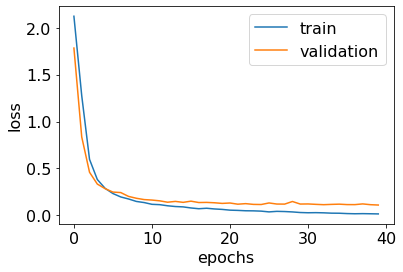

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation']);

- Important idea: 
  - Opimizing the model more causes training loss to keep going down.
  - But it may cause test error to go up.
  - Maybe we don't want to do a good job of our optimization?!?
- **Early stopping**: if the model starts to overfit, stop the optimization.
- We are letting Step 3 (pick your optimizer) influence the fundamental tradeoff!
- This makes everything much more foggy in our minds - but can still be useful.
- We actually saw some of this in lab 2 with `LogisticRegression` vs. `SGDClassifier`. 

Note: it is easy to confuse the above type of plot with this type of plot, below:

In [27]:
train_errs = list()
test_errs = list()
layer_sizes = [10,25,50,100,200,300,500,750,1000]
for layer_size in layer_sizes:
    print(layer_size, end=" ")
    model = Sequential()
    model.add(Dense(layer_size, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history2 = model.fit(X_train, Y_train, epochs=10, verbose=0)
    
    train_errs.append( 1 - model.evaluate(X_train, Y_train, verbose=0)[1] )
    test_errs.append(  1 - model.evaluate(X_test,  Y_test,  verbose=0)[1] )    

10 25 50 100 200 300 500 750 1000 

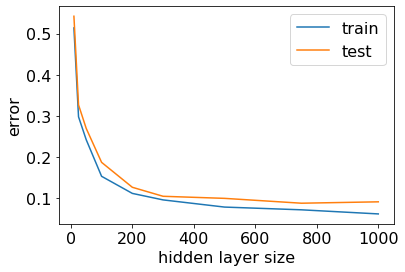

In [28]:
plt.plot(layer_sizes, train_errs, label="train")
plt.plot(layer_sizes, test_errs, label="test")
plt.legend()
plt.xlabel("hidden layer size");
plt.ylabel("error");

- These figures look similar but are plotting completely different things!!!
- Let's take a minute to digest.

## Hyperparameters (5 min)


#### Hyperparameters

- Neural networks have potentially a lot of hyperparameters.
- The first choice is the number of layers. Then...
- Each layer can have its own set of hyperparameters (or this could be the same across layers), such as
  - Dimensionality
  - Activation function
  - Regularization; more on this next class
  - ...
- Then we also have the optimization hyperparameters
  - Initialization
  - Learning rate(s)
  - Momentum
  - ...
- As usual, the hyperparameters control the fundamental tradeoff of ML
  - With no hidden layers, we have linear/logistic regression.
  - More features --> more weights --> lower training error. 
  - Now we can expand the model complexity by adding layers, without collecting more features.

- You've covered regularization in DSCI 573.
- Neural nets use some standard regularization and some funny ones
- _Weight decay_: just a name for L2-regularization on the weights
- [Batch normalization](https://arxiv.org/abs/1502.03167) normalizes values during training
- Dropout: randomly delete (set to 0) your activations
  - this sounds crazy but there's a lot of intuition here
  - preventing co-adaptation
  - has an interpretation as ensembling models with different architectures

## (optional) Backpropagation


The squared loss (a not-uncommon choice for regression) is

$$f\left(\{W^{(l)}\}\right)= \sum_{i=1}^n \left(y_i - \hat{y}_i\right)^2  $$

Let's digest this...

- by $\{W^{(l)}\}$ I mean the set of all $W$'s and all their elements
- by $\hat{y}_i$ I mean our prediction for example $x_i$, which we get from applying our recurrence relation $L$ times.

We need $\nabla f(W)$, which is the same as saying we need all the partial derivatives $\frac{\partial f}{\partial W_{ij}}$.

This is done via the chain rule. But we need to be careful not to _recompute_ things (remember dynamic programming? it was all about not recomputing things). 

We can draw a graph of what depends on what. Consider $\frac{\partial f}{\partial W^{(0)}_{11}}$ and $\frac{\partial f}{\partial W^{(0)}_{12}}$. These two derivatives have a lot in commmon, namely...

$$ \frac{\partial f}{\partial x^{(L)}} \frac{\partial x^{(L)}}{\partial x^{(L-1)}} \cdots \frac{\partial x^{(2)}}{\partial x^{(1)}} \frac{\partial x^{(1)}}{\partial W^{(0)}}$$ 

only the last part is different.

- The method for applying the chain rule and not re-computing anything is called **backpropagation** or backprop for short. 
- Backprop is reverse-mode differentiation. So packages like [AutoGrad](https://github.com/HIPS/autograd) do it "for free".
- Once we have the gradient, we can train with (stochastic) gradient descent. 


## Convolutions (10 min)

- What is a convolution?
- Convolutions appear all over the field of _signal processing_, which is traditionally a discipline within electrical engineering. But they also show up in math, physics, CS, etc. A lot of communications theory is based on this stuff.
- What is a linear operator/transformation?
  - in the discrete world, anything that can be represented as a matrix multiplication
- 1-D convolutions
- 2-D and higher-D convolutions
- Boundary conditions: the output might be slightly bigger or slightly smaller, or the same
  - these are the options in [scipy.signal.convolve2d](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.convolve2d.html)
- Convolution is often written as $x \ast y$ 
- Convolution is commutative: $x \ast y = y \ast x$
  - Nonetheless, we often have a "signal" and a "filter" and they have different interpretations
  - The filter is often small and has an interpretation like "highpass" or "lowpass"


- (optional): there is a fast implementations of convolution using the FFT (fast Fourier transform). For an $n\times n$ image and $m\times m$ filter this takes $nm\log(nm)$ time instead of $n^2m^2$. For sufficiently big images and filters this is a big win BUT there's a catch, which is that the equivalence only holds for periodic boundary conditions. 


## True/false - convolutions (15 min)



1. Convolving with the filter $w=[0.2, 0.2, 0.2, 0.2, 0.2]$ performs a local averaging operation.
2. For a convolution to be valid, the values in the filter must add up to $1$ (e.g. $w=[0,1,0], w=\left[\frac13,\frac13,\frac13\right]$, etc).
3. 1D convolution is just a special case of 2D convolution where one of the dimensions of $w$ and $x$ happens to be 1.
4. The convolution of a filter $w$ and signal $x$ is equivalent to the matrix multiplication $w^Tx$.

<br><br><br><br><br><br><br><br>